#***Experimenting LSTM for counting syllables in words***


This notebook is used for developing model in the phase 1. The model used is unidirectional LSTM.
 

In [1]:
#import all used library
import pandas as pd
import torch
import numpy as np 
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import math
import os
import time
import datetime
import matplotlib.pyplot as pyplot
from sklearn.utils import shuffle

In [2]:
#Load data using pandas
path_to_dictionary = '/content/converted_syllable_dict.csv'
print('Parsing the dataset .csv file...')
dictionary = pd.read_csv(path_to_dictionary)
dictionary = shuffle(dictionary)
print(dictionary)
print('Finished')



Parsing the dataset .csv file...
                 word  syllable_count
32098       downsides               2
84812           penis               2
92183   realistically               5
26376          dahl's               1
9315         beilfuss               2
...               ...             ...
20468       civilized               3
119332       vertebra               3
63650          lashes               2
11313          blaine               1
74349    misinforming               4

[125914 rows x 2 columns]
Finished


In [3]:
words = dictionary['word']
myWords = []
for word in words:
    myWords.append(str(word).lower())
myCounts = dictionary['syllable_count']
count_list =[]
for count in myCounts:
    count_list.append(count * 1000)
counts = np.array(count_list) #convert count_list into np.array

In [4]:
all_words = ' '.join(str(myWords))
chars = all_words.split()
counters = Counter(chars)
char_list = sorted(counters, key=counters.get, reverse=True)
char_to_int = {char: ii for ii, char in enumerate(char_list, 1)}
print(char_to_int)

words_ints =[]
for word in myWords:
    words_ints.append([char_to_int[char] for char in str(word)])


{"'": 1, ',': 2, 'e': 3, 'a': 4, 'r': 5, 'i': 6, 's': 7, 'n': 8, 'o': 9, 't': 10, 'l': 11, 'c': 12, 'd': 13, 'm': 14, 'u': 15, 'h': 16, 'g': 17, 'p': 18, 'b': 19, 'k': 20, 'y': 21, '"': 22, 'f': 23, 'w': 24, 'v': 25, 'z': 26, 'j': 27, 'x': 28, 'q': 29, '-': 30, '.': 31, '[': 32, '1': 33, ']': 34}


In [5]:
len_word = [len(word) for word in myWords]
max_length = max(len_word)
print(max_length)

28


In [6]:
def pad_words(words, length):
  features = np.zeros((len(words), length), dtype=int)
  for i, row in enumerate(words):
    features[i, -len(row):] = np.array(row)[:length]
  return features

In [7]:
myLength = max_length
features = pad_words(words_ints, myLength)
print(features[-30:, -10:])
print(len(features))


[[ 0  0 18  5  9 10  5 15 13  3]
 [ 0  0  0  0 19  6  3 19  3  5]
 [ 0  0  0 17  5  6 23 23  3  3]
 [ 0  0 20  6 20 20  9 14  4  8]
 [ 0  0  7 12 16  5  3  6  3  5]
 [ 0  0  8  3 24 25  6 11 11  3]
 [ 4 10  4 18  9  6  8 10  1  7]
 [ 5 20  6  8  7  9  8  6  7 14]
 [ 0  0  0  0  0  0  8 15 13  9]
 [ 0  0  0  0  0  0 17  9 10  9]
 [ 0  0  0  0  5  3 13  3 11 11]
 [ 0  0  7  6 11  3  8 12  3  7]
 [ 0  0  0 16 15  5  5  6  3  7]
 [ 3 10 16  3  5 11  4  8 13  7]
 [ 0  0  0  0  0  0 17  6  5 10]
 [ 0  0  0  0  0 16  4 11 11  3]
 [ 0  0  0 27  4 12  9 19 15  7]
 [10 24  4  5 13  9 24  7 20  6]
 [ 0  0  0  0  0  0 19  9 14 19]
 [ 0  0  7 10 30 13  3  8  6  7]
 [ 0 18  4  5 10 16  3  8  9  8]
 [ 0  0 11  3  6  7 16 14  4  8]
 [ 0 14  4 12 20  9 24  7 20  6]
 [ 0  0 12 15 11 11 15 14  1  7]
 [19  7  3  5 25  4 10  6  9  8]
 [ 0 12  6 25  6 11  6 26  3 13]
 [ 0  0 25  3  5 10  3 19  5  4]
 [ 0  0  0  0 11  4  7 16  3  7]
 [ 0  0  0  0 19 11  4  6  8  3]
 [ 7  6  8 23  9  5 14  6  8 17]]
125914


In [8]:
split_frac = 0.9
## split data into training, validation, and test data (features and labels, x and y)
split_idx = int(len(features)*split_frac)
print(split_idx)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = counts[:split_idx], counts[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

113322
			Feature Shapes:
Train set: 		(113322, 28) 
Validation set: 	(6296, 28) 
Test set: 		(6296, 28)


In [9]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [10]:
import torch
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [11]:
class LSTM(nn.Module):


    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers):
        """
        Initialize the model by setting up the layers.
        """
        super(LSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        #dropout layers
        self.dropout = nn.Dropout(0.2)
        # linear layers
        self.fc1 = nn.Linear(hidden_dim, 256)
        self.fc2 = nn.Linear(256, output_size)

        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        # fully-connected layer
        out = nn.functional.relu(self.fc1(lstm_out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        # reshape to be batch_size first
        out = out.view(batch_size, -1)
        out = out[:, -1] # get last batch of labels
        
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [12]:
vocab_size = len(char_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 100
hidden_dim = 256
n_layers = 2

net_lstm = LSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print('LSTM \n', net_lstm )

LSTM 
 LSTM(
  (embedding): Embedding(35, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)


In [13]:
# loss and optimization functions
lr=0.0005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net_lstm.parameters(), lr=lr)

In [14]:
#functions used for training models
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def save_model(filename, decoder):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(decoder, save_filename)

def load_model(filename):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    return torch.load(save_filename)

In [15]:
epochs = 10 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

#lists used for plotting losses
step_list = list()
train_loss_list = list()
val_loss_list = list()

# move model to GPU, if available
if(train_on_gpu):
    net_lstm.cuda()

#use min_loss to track the best model throughout the training loop
min_val_loss = math.inf

net_lstm.train()
# train for some number of epochs
for e in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(e + 1, epochs))
    print('Training...')

    t0 = time.time()

    # initialize hidden state
    h = net_lstm.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net_lstm.zero_grad()

        # get the output from the model
        output, _ = net_lstm(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net_lstm.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            elapsed = format_time(time.time() - t0)

            # Get validation loss
            val_h = net_lstm.init_hidden(batch_size)
            val_losses = []
            net_lstm.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net_lstm(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())
            

            net_lstm.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)),
                  "Time: {:}".format(elapsed))
            if np.mean(val_losses) < min_val_loss:
                min_val_loss = np.mean(val_losses)
                save_model('./save/trained_lstm', net_lstm)
                print('Model Trained and Saved')
            step_list.append(counter)
            train_loss_list.append(loss.item())
            val_loss_list.append(np.mean(val_losses))


======== Epoch 1 / 10 ========
Training...
Epoch: 1/10... Step: 100... Loss: 7037529.000000... Val Loss: 6410347.000000 Time: 0:00:02
Model Trained and Saved
Epoch: 1/10... Step: 200... Loss: 5112251.000000... Val Loss: 5480363.340000 Time: 0:00:04
Model Trained and Saved
Epoch: 1/10... Step: 300... Loss: 4121836.000000... Val Loss: 4228218.100000 Time: 0:00:06
Model Trained and Saved
Epoch: 1/10... Step: 400... Loss: 3486879.250000... Val Loss: 2855048.710000 Time: 0:00:09
Model Trained and Saved
Epoch: 1/10... Step: 500... Loss: 1555256.250000... Val Loss: 1647837.214000 Time: 0:00:11
Model Trained and Saved
Epoch: 1/10... Step: 600... Loss: 1612607.125000... Val Loss: 985261.447250 Time: 0:00:13
Model Trained and Saved
Epoch: 1/10... Step: 700... Loss: 924717.000000... Val Loss: 958156.428750 Time: 0:00:16
Model Trained and Saved
Epoch: 1/10... Step: 800... Loss: 911599.312500... Val Loss: 958815.454250 Time: 0:00:18
Epoch: 1/10... Step: 900... Loss: 717890.625000... Val Loss: 7030

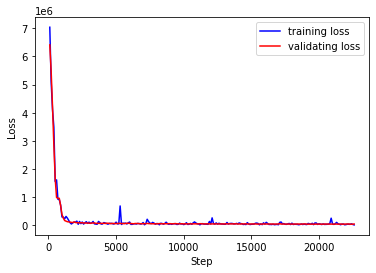

In [16]:
#Plotting loss
pyplot.plot(step_list, train_loss_list, color='blue', label='training loss')
pyplot.plot(step_list, val_loss_list, color='red', label='validating loss')
pyplot.legend()
pyplot.xlabel('Step')
pyplot.ylabel('Loss')
pyplot.show()

In [17]:

test_losses = [] # track loss
num_correct = 0

net_lstm = load_model('./save/trained_lstm') #load the saved model

h = net_lstm.init_hidden(batch_size)

net_lstm.eval()

for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net_lstm(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze()/1000)  # rounds to the nearest integer
    original_labels = labels // 1000
    # compare predictions to true label
    correct_tensor = pred.eq(original_labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

    # -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy of LSTM networks: {:.3f}".format(test_acc))

Test loss: 46859.959
Test accuracy of LSTM networks: 0.945


In [18]:
def tokenize_word(words):

  
    test_ints = []
    for word in words:
      word = word.lower()
      test_ints.append([char_to_int[char] for char in word])
    test_ints = pad_words(test_ints, 28)
    return test_ints

def predict(net, words):
    
    net.eval()
    

    test_ints = tokenize_word(words)
    print(test_ints)
    

    features = np.array(test_ints)
    

    feature_tensor = torch.from_numpy(features)
    batch_size =  feature_tensor.size(0)
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    
    pred = torch.round(output.squeeze()/1000)
    print(pred.data) 
    # printing output value, before rounding
    print('Prediction value, pre-rounding: ', (output.data))
  

In [19]:
predict(net_lstm, ('tranquocson','tonikroos'))

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  5  4  8 29 15  9
  12  7  9  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  9  8  6 20
   5  9  9  7]]
tensor([3., 3.], device='cuda:0')
Prediction value, pre-rounding:  tensor([2974.3708, 3030.5068], device='cuda:0')
